In [1]:
%%capture

!pip install transformers diffusers accelerate -U
!pip install parediffusers

In [3]:
import torch
from parediffusers import PareDiffusionPipeline

pipe = PareDiffusionPipeline.from_pretrained(
	"stabilityai/stable-diffusion-2",
	device=torch.device("cuda"),
	dtype=torch.float16,
)

/usr/local/lib/python3.9/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [4]:
timesteps, num_inference_steps = pipe.retrieve_timesteps(50)
timesteps

tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')

In [20]:
# Last timesteps
timesteps[-1] - pipe.scheduler.config.num_train_timesteps // pipe.scheduler.num_inference_steps

tensor(-19)

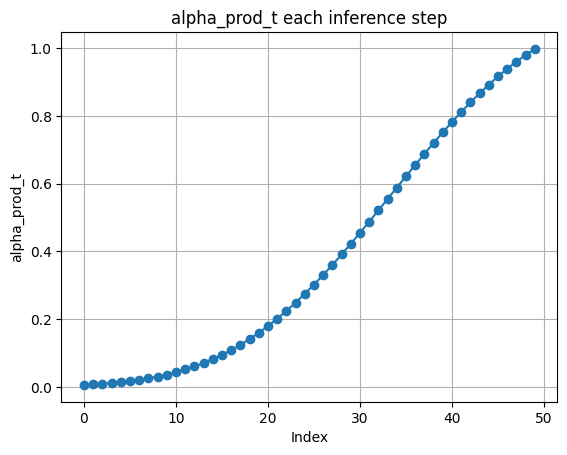

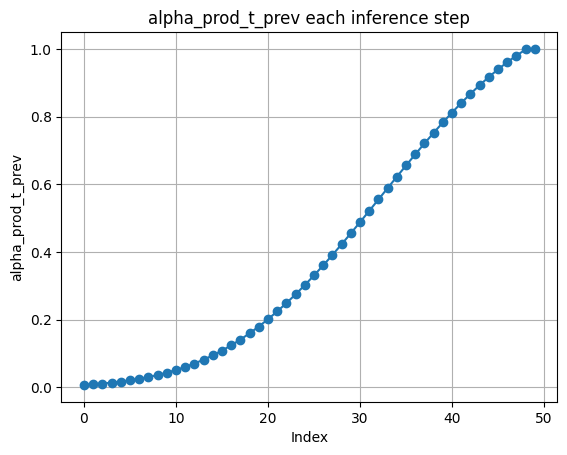

In [13]:
import matplotlib.pyplot as plt

def get_step(pipe, timestep):
	prev_timestep = timestep - pipe.scheduler.config.num_train_timesteps // pipe.scheduler.num_inference_steps

	alpha_prod_t = pipe.scheduler.alphas_cumprod[timestep]
	alpha_prod_t_prev = pipe.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else pipe.scheduler.final_alpha_cumprod
	return {"alpha_prod_t": alpha_prod_t, "alpha_prod_t_prev": alpha_prod_t_prev}

# Generate x values (indices)
x_values = range(num_inference_steps)
timesteps = timesteps.to("cpu")
steps = [get_step(pipe, timestep) for timestep in timesteps]
alpha_prod_ts = [step["alpha_prod_t"] for step in steps]
alpha_prod_t_prevs = [step["alpha_prod_t_prev"] for step in steps]

# Plot
plt.plot(x_values, alpha_prod_ts, marker='o', linestyle='-')
plt.xlabel('Index')
plt.ylabel('alpha_prod_t')
plt.title('alpha_prod_t each inference step')
plt.grid(True)
plt.show()

plt.plot(x_values, alpha_prod_t_prevs, marker='o', linestyle='-')
plt.xlabel('Index')
plt.ylabel('alpha_prod_t_prev')
plt.title('alpha_prod_t_prev each inference step')
plt.grid(True)
plt.show()


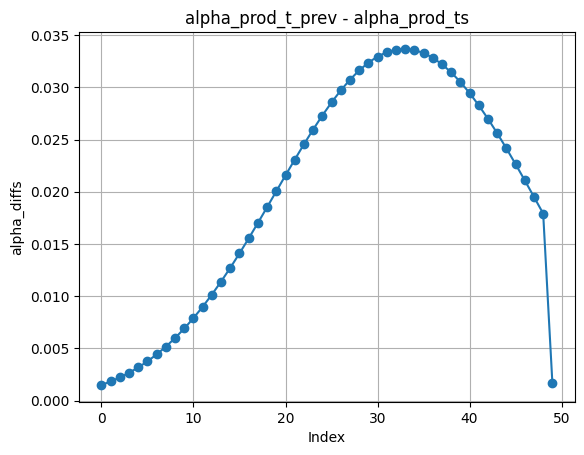

In [14]:
alpha_diffs = [alpha_prod_t_prev - alpha_prod_t for alpha_prod_t_prev, alpha_prod_t in zip(alpha_prod_t_prevs, alpha_prod_ts)]

plt.plot(x_values, alpha_diffs, marker='o', linestyle='-')
plt.xlabel('Index')
plt.ylabel('alpha_diffs')
plt.title('alpha_prod_t_prev - alpha_prod_ts')
plt.grid(True)
plt.show()